## Sparkify Capstone Project (Predicting the user churn)

In [2]:
import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': '457ujvkZFpxzaSpTVd17JZcXboCkhgFD9oRYrmkNF-Bh',
    'service_id': 'iam-ServiceId-f8a7d4db-3036-49fd-b9b5-db115af6ca48',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token'}

configuration_name = 'os_f68250162c014fe99aa26a4b35ce9144_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-ywhilf027ygkgf'))
df_data_1.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import re
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids.

In [4]:
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df_data_1.createOrReplaceTempView("df_log")

In [6]:
spark.sql("SELECT DISTINCT level FROM df_log").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [7]:
#We will use cancellation confirmation page as the keywords whether the user churn or not
spark.sql("SELECT page, COUNT(*) AS num FROM df_log GROUP BY page ORDER BY num DESC").show(30)

+--------------------+------+
|                page|   num|
+--------------------+------+
|            NextSong|432877|
|                Home| 27412|
|           Thumbs Up| 23826|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|         Roll Advert|  7773|
|               Login|  6011|
|              Logout|  5990|
|         Thumbs Down|  4911|
|           Downgrade|  3811|
|                Help|  3150|
|            Settings|  2964|
|               About|  1855|
|             Upgrade|   968|
|       Save Settings|   585|
|               Error|   519|
|      Submit Upgrade|   287|
|    Submit Downgrade|   117|
|              Cancel|    99|
|Cancellation Conf...|    99|
|            Register|    11|
| Submit Registration|     4|
+--------------------+------+



In [8]:
#There are some missing userID record
spark.sql("SELECT DISTINCT userID, COUNT(*) AS num FROM df_log GROUP BY userID ORDER BY userID ASC").show()

+------+-----+
|userID|  num|
+------+-----+
|      |15700|
|    10|  423|
|   100| 3999|
|100001|  134|
|100002|  177|
|100003|  827|
|100004|  373|
|100005|  100|
|100006|  375|
|100007| 1052|
|100008|  463|
|100009| 2987|
|100010|  137|
|100011| 1303|
|100012|  167|
|100013|   27|
|100014|  406|
|100015|  529|
|100016|  200|
|100017|  178|
+------+-----+
only showing top 20 rows



In [9]:
#there is no missing sessionID
spark.sql("SELECT DISTINCT sessionID, COUNT(*) AS num FROM df_log GROUP BY sessionID ORDER BY sessionID ASC").show()

+---------+---+
|sessionID|num|
+---------+---+
|        1|178|
|        2| 62|
|        3| 87|
|        4| 98|
|        5|121|
|        6|120|
|        7| 22|
|        9|642|
|       10|298|
|       11|280|
|       12| 80|
|       13| 72|
|       15|122|
|       16| 88|
|       17|527|
|       18|140|
|       19| 11|
|       20| 38|
|       21| 73|
|       22| 33|
+---------+---+
only showing top 20 rows



In [10]:
#drop null userID
df = df_data_1.filter(df_data_1.userId != '')

In [11]:
df.count()

528005

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
#Define Churn
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [13]:
df_churn = df.withColumn("churn", churn_event("page"))
df_churn.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', churn=0)]

In [14]:
df_churn.createOrReplaceTempView("df_churn_log")

In [15]:
spark.sql("SELECT COUNT(DISTINCT userID) AS num_user_churn FROM df_churn_log WHERE churn=1").show()
#there are 99 users churn from our dataset

+--------------+
|num_user_churn|
+--------------+
|            99|
+--------------+



In [16]:
spark.sql("SELECT COUNT(DISTINCT userID) AS num_user FROM df_churn_log").show()
#there are altogether 448 users in our dataset

+--------+
|num_user|
+--------+
|     448|
+--------+



In [17]:
#create a table indicating for each user, whether he/she churned or not?
user_churn = spark.sql("SELECT userID, SUM(churn) AS churn_d FROM df_churn_log GROUP BY userID")
user_churn.show()

+------+-------+
|userID|churn_d|
+------+-------+
|100010|      1|
|200002|      1|
|   296|      1|
|   125|      0|
|    51|      1|
|   124|      1|
|     7|      0|
|200037|      1|
|   169|      0|
|   205|      0|
|   272|      0|
|   282|      0|
|   232|      0|
|    15|      0|
|    54|      1|
|   234|      1|
|200043|      0|
|   155|      0|
|100014|      1|
|   154|      1|
+------+-------+
only showing top 20 rows



In [18]:
#or we could use partition by as well.
data_log_new = spark.sql("SELECT a.*, b.churn_d\
                          FROM \
                              df_churn_log AS a \
                          INNER JOIN \
                              (SELECT userID, SUM(churn) AS churn_d \
                               FROM df_churn_log \
                               GROUP BY userID) AS b \
                          ON a.userID=b.userID")
data_log_new.createOrReplaceTempView("data_log_new")
data_log_new.take(1)

[Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, churn_d=1)]

In [48]:
#avg time to listen
p1 = data_log_new \
        .select('userID','length','churn_d') \
        .groupBy('userID','churn_d') \
        .agg({'length':'sum'}) \
        .withColumnRenamed('sum(length)', 'listen_time') \
        .select('churn_d','listen_time') \
        .groupBy('churn_d') \
        .agg({'listen_time':'avg'})
p1.show()

+-------+------------------+
|churn_d|  avg(listen_time)|
+-------+------------------+
|      0|248241.54574739255|
|      1| 212170.5400305049|
+-------+------------------+



Text(0.5,1,'Average Listen Time Between Two Groups')

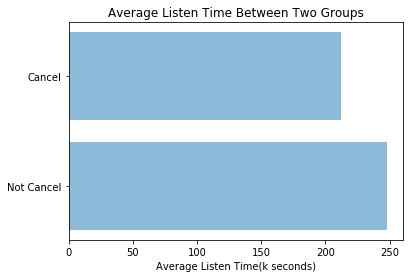

In [55]:
importances = [248.241,212.170]
churn_d = ['Not Cancel','Cancel']
y_pos = np.arange(len(churn_d))
 
plt.barh(y_pos, importances, align='center', alpha=0.5)
plt.yticks(y_pos, churn_d)
plt.xlabel('Average Listen Time(k seconds)')
plt.title('Average Listen Time Between Two Groups')

In [20]:
#nubmer of song to listen
data_log_new \
        .select('userID','song','churn_d') \
        .groupBy('userID','churn_d') \
        .agg({'song':'count'}) \
        .withColumnRenamed('count(song)', 'num_song') \
        .select('churn_d','num_song') \
        .groupBy('churn_d') \
        .agg({'num_song':'avg'}).show()

+-------+-----------------+
|churn_d|    avg(num_song)|
+-------+-----------------+
|      0|998.6189111747851|
|      1|852.1111111111111|
+-------+-----------------+



Text(0.5,1,'Average Number of Songs Listened Between Two Groups')

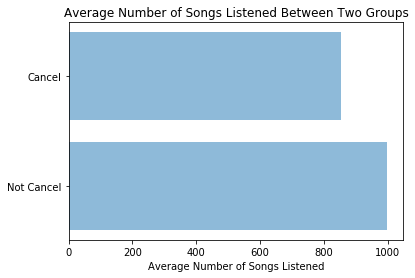

In [56]:
importances = [998.618,852.111]
churn_d = ['Not Cancel','Cancel']
y_pos = np.arange(len(churn_d))
 
plt.barh(y_pos, importances, align='center', alpha=0.5)
plt.yticks(y_pos, churn_d)
plt.xlabel('Average Number of Songs Listened')
plt.title('Average Number of Songs Listened Between Two Groups')

In [21]:
#number of thumb-up and thumb_down
data_log_new \
        .select('userID','page','churn_d') \
        .where(data_log_new.page == 'Thumbs Down') \
        .groupBy('userID','churn_d') \
        .agg({'page':'count'}) \
        .withColumnRenamed('count(page)', 'num_thumb_down') \
        .select('churn_d','num_thumb_down') \
        .groupBy('churn_d') \
        .agg({'num_thumb_down':'avg'}).show()

+-------+-------------------+
|churn_d|avg(num_thumb_down)|
+-------+-------------------+
|      0| 12.516666666666667|
|      1|  12.98876404494382|
+-------+-------------------+



In [22]:
data_log_new \
        .select('userID','page','churn_d') \
        .where(data_log_new.page == 'Thumbs Up') \
        .groupBy('userID','churn_d') \
        .agg({'page':'count'}) \
        .withColumnRenamed('count(page)', 'num_thumb_up') \
        .select('churn_d','num_thumb_up') \
        .groupBy('churn_d') \
        .agg({'num_thumb_up':'avg'}).show()

+-------+-----------------+
|churn_d|avg(num_thumb_up)|
+-------+-----------------+
|      0|57.26099706744868|
|      1|43.87755102040816|
+-------+-----------------+



Text(0.5,1,'Average Number of Thumb-up Between Two Groups')

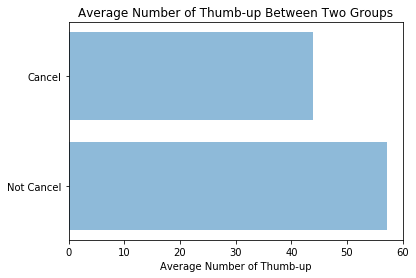

In [57]:
importances = [57.2609,43.8775]
churn_d = ['Not Cancel','Cancel']
y_pos = np.arange(len(churn_d))
 
plt.barh(y_pos, importances, align='center', alpha=0.5)
plt.yticks(y_pos, churn_d)
plt.xlabel('Average Number of Thumb-up')
plt.title('Average Number of Thumb-up Between Two Groups')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [23]:
#feature
#number of total time spent
d1 = data_log_new \
        .select('userID','length') \
        .groupBy('userID') \
        .agg({'length':'sum'}) \
        .withColumnRenamed('sum(length)', 'listen_time')
#number of songs listened to
d2 = data_log_new \
        .select('userID','song') \
        .groupBy('userID') \
        .agg({'song':'count'}) \
        .withColumnRenamed('count(song)', 'num_song')
#number of thumb-up, thumb-down
d3 = data_log_new \
        .select('userID','page') \
        .where(data_log_new.page == 'Thumbs Down') \
        .groupBy('userID') \
        .agg({'page':'count'}) \
        .withColumnRenamed('count(page)', 'num_thumb_down')
d4 = data_log_new \
        .select('userID','page') \
        .where(data_log_new.page == 'Thumbs Up') \
        .groupBy('userID') \
        .agg({'page':'count'}) \
        .withColumnRenamed('count(page)', 'num_thumb_up') 
#number of add to playlist
d5 = data_log_new \
        .select('userID','page') \
        .where(data_log_new.page == 'Add to Playlist') \
        .groupBy('userID') \
        .agg({'page':'count'}) \
        .withColumnRenamed('count(page)', 'add_to_playlist')
#number of lifetime
d6 = data_log_new \
        .select('userID','registration','ts') \
        .withColumn('lifetime',(data_log_new.ts-data_log_new.registration)) \
        .groupBy('userID') \
        .agg({'lifetime':'max'}) \
        .withColumnRenamed('max(lifetime)','lt')
#number of add to playlist
d7 = data_log_new \
        .select('userID','page') \
        .where(data_log_new.page == 'Add Friend') \
        .groupBy('userID') \
        .agg({'page':'count'}) \
        .withColumnRenamed('count(page)', 'add_friend') 
#number of help/rolladvert
d8 = data_log_new \
        .select('userID','page') \
        .where(data_log_new.page == 'Help') \
        .groupBy('userID') \
        .agg({'page':'count'}) \
        .withColumnRenamed('count(page)', 'help') 
d9 = data_log_new \
        .select('userID','page') \
        .where(data_log_new.page == 'Roll Advert') \
        .groupBy('userID') \
        .agg({'page':'count'}) \
        .withColumnRenamed('count(page)', 'rolladvert') 

In [24]:
# join multiple table together
dt = d1.join(d2,'userID','outer') \
    .join(d3,'userID','outer') \
    .join(d4,'userID','outer') \
    .join(d5,'userID','outer') \
    .join(d6,'userID','outer') \
    .join(d7,'userID','outer') \
    .join(d8,'userID','outer') \
    .join(d9,'userID','outer') \
    .join(user_churn,'userID','outer') \
    .drop('userID') \
    .fillna(0)

In [25]:
dt.show(5)

+------------------+--------+--------------+------------+---------------+----------+----------+----+----------+-------+
|       listen_time|num_song|num_thumb_down|num_thumb_up|add_to_playlist|        lt|add_friend|help|rolladvert|churn_d|
+------------------+--------+--------------+------------+---------------+----------+----------+----+----------+-------+
|25870.950739999997|      96|             3|           4|              1|1237978000|         3|   0|        22|      1|
| 78695.82683999998|     310|             5|          15|              6|4607120000|         2|   1|        11|      1|
|28314.150059999996|     112|             0|           8|              3|2301546000|         2|   2|         9|      1|
|15813.771070000003|      62|             1|           3|              2|9108471000|         3|   2|         6|      0|
|456664.04057999986|    1826|            15|         102|             45|9724648000|        26|  10|         1|      1|
+------------------+--------+-----------

In [26]:
dt.count()

448

In [27]:
#construct a vector
incol = ["listen_time", "num_song", "num_thumb_down", \
          'num_thumb_up','add_to_playlist','lt','add_friend','help','rolladvert']
assembler = VectorAssembler(inputCols=incol, outputCol="NumFeatures")
dt = assembler.transform(dt)

In [28]:
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures2", withStd=True)
scalerModel = scaler2.fit(dt)
dt = scalerModel.transform(dt)

In [29]:
dt.take(2)

[Row(listen_time=25870.950739999997, num_song=96, num_thumb_down=3, num_thumb_up=4, add_to_playlist=1, lt=1237978000, add_friend=3, help=0, rolladvert=22, churn_d=1, NumFeatures=DenseVector([25870.9507, 96.0, 3.0, 4.0, 1.0, 1237978000.0, 3.0, 0.0, 22.0]), ScaledNumFeatures2=DenseVector([0.0904, 0.0834, 0.2246, 0.0574, 0.0297, 0.3534, 0.1351, 0.0, 1.028])),
 Row(listen_time=78695.82683999998, num_song=310, num_thumb_down=5, num_thumb_up=15, add_to_playlist=6, lt=4607120000, add_friend=2, help=1, rolladvert=11, churn_d=1, NumFeatures=DenseVector([78695.8268, 310.0, 5.0, 15.0, 6.0, 4607120000.0, 2.0, 1.0, 11.0]), ScaledNumFeatures2=DenseVector([0.2749, 0.2694, 0.3743, 0.2154, 0.1782, 1.3151, 0.0901, 0.1367, 0.514]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [30]:
dt2 = dt.select(col('churn_d').alias('label'),col('ScaledNumFeatures2').alias('features'))
dt2.take(1)

[Row(label=1, features=DenseVector([0.0904, 0.0834, 0.2246, 0.0574, 0.0297, 0.3534, 0.1351, 0.0, 1.028]))]

In [31]:
rest,validation = dt2.randomSplit([0.8, 0.2], seed=50)

In [32]:
#we train three different models: logistic regression, svm and gradient boosting tree
logit = LogisticRegression(maxIter=10,regParam=0.0)
gbt = GBTClassifier(maxDepth=5,maxIter=10,seed=42)
svm = LinearSVC(maxIter=10, regParam=0.01)

In [33]:
#Logistic Regression
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(logit.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=logit,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)

In [64]:
cvModel_q1 = crossval.fit(rest)
#report the f1 score 
cvModel_q1.avgMetrics

[0.7146602298840452, 0.7012620769260017, 0.6903366038525016]

In [34]:
#Support Vector Machine
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam,[0.01, 0.05, 0.5]) \
    .build()
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)

In [35]:
cvModel_q2 = crossval.fit(rest)
cvModel_q2.avgMetrics

[0.6780940226372448, 0.6780940226372448, 0.6780940226372448]

In [36]:
#gradient boosted tree models
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)

In [37]:
cvModel_q3 = crossval.fit(rest)
cvModel_q3.avgMetrics

[0.7621021634840353, 0.7160764202188692]

#### Conclusion
Among the three models we've been trained:
-  logistic regression (best f1 score 0.7147)
-  graident boosted tree (best f1 score 0.7621 )
-  supported vector machine (best f1 score 0.6781)

We decided to choose gradient boosted tree as the best model with tunned parameter (maxDepth=5).
And we fit our best model on the validation set. And we look at the feature importance as well.

**Score on the final validation set**
- Accuracy: 0.7816
- F1 Score: 0.7416

In [33]:
gbt_best = GBTClassifier(maxDepth=5,maxIter=10,seed=42)

In [34]:
gbt_model = gbt_best.fit(rest)

In [35]:
results = gbt_model.transform(validation)

In [36]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))

0.7816091954022989


In [37]:
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

0.741624623929646


In [43]:
gbt_model.featureImportances

SparseVector(9, {0: 0.1057, 1: 0.0515, 2: 0.1145, 3: 0.149, 4: 0.0458, 5: 0.195, 6: 0.1265, 7: 0.0748, 8: 0.1373})

Text(0.5,1,'GBT Feature Importances')

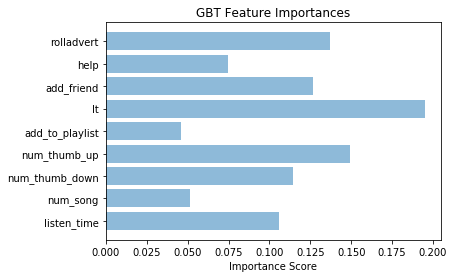

In [46]:
importances = [0.1057, 0.0515, 0.1145, 0.149, 0.0458, 0.195, 0.1265, 0.0748, 0.1373]
feature = ["listen_time", "num_song", "num_thumb_down", \
          'num_thumb_up','add_to_playlist','lt','add_friend','help','rolladvert']
y_pos = np.arange(len(feature))
 
plt.barh(y_pos, importances, align='center', alpha=0.5)
plt.yticks(y_pos, feature)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.